# Лабораторная работа №2. Бинарный классификатор
Пан Анатолий Эдуардович<br>
Группа 932209<br>
Вариант Horses or humans

Импорт необходимых модулей и библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

Загружаем датасет "Horses or humans" из Kaggle

In [3]:
# Install kaggle
!pip install -q kaggle

In [4]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Change directory
import os
os.chdir("/content/drive/MyDrive/masters/Neural networks/lab_2")

In [6]:
# Create a kaggle folder
!mkdir -p ~/.kaggle

# Copy kaggle.json to created folder
!cp kaggle.json ~/.kaggle/

In [7]:
os.chdir("/content")

In [8]:
# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
# Download the required dataset
!kaggle datasets download -d sanikamal/horses-or-humans-dataset

 95% 292M/307M [00:01<00:00, 217MB/s]
100% 307M/307M [00:01<00:00, 226MB/s]


In [10]:
# Unzip our dataset
from zipfile import ZipFile
from tqdm import tqdm


file_to_extract = "horses-or-humans-dataset.zip"

# Open your .zip file
with ZipFile(file=file_to_extract) as zip_file:

    # Loop over each file and extract them
    for file in tqdm(iterable=zip_file.namelist(), total=len(zip_file.namelist())):
        zip_file.extract(member=file)

100%|██████████| 2566/2566 [00:02<00:00, 993.71it/s] 


Пути к обучающей и тестовой выборкам

In [11]:
# Data separation
train_dir = '/content/horse-or-human/train'
val_dir = '/content/horse-or-human/validation'

Постоянные значения

In [12]:
width = 150
height = 150
color = 3
batch_size = 32

ImageDataGenerator позволяет легко маркировать и загружать большие наборы данных изображений. Здесь мы создаем два объекта для ImageDataGenerator, а также масштабируем изображение так, чтобы значения их пикселей были нормализованы между 0 и 1, не влияя на качество изображения, что облегчит обучение CNN

In [13]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255,  # Масштабирование значений пикселей в диапазоне [0, 1]
                                   rotation_range=20,  # Случайные повороты изображения
                                   width_shift_range=0.2,  # Случайное горизонтальное смещение
                                   height_shift_range=0.2,  # Случайное вертикальное смещение
                                   shear_range=0.2,  # Случайное смещение
                                   zoom_range=0.2,  # Случайное увеличение
                                   horizontal_flip=True,  # Случайное отражение по горизонтали
                                   fill_mode='nearest'  # Заполнение пикселей после преобразований
                                   )

In [14]:
val_datagen = ImageDataGenerator(rescale=1.0 / 255,  # Масштабирование значений пикселей в диапазоне [0, 1]
                                 rotation_range=20,  # Случайные повороты изображения
                                 width_shift_range=0.2,  # Случайное горизонтальное смещение
                                 height_shift_range=0.2,  # Случайное вертикальное смещение
                                 shear_range=0.2,  # Случайное смещение
                                 zoom_range=0.2,  # Случайное увеличение
                                 horizontal_flip=True,  # Случайное отражение по горизонтали
                                 fill_mode='nearest'  # Заполнение пикселей после преобразований
                                 )

Затем мы используем эти объекты для вызова метода потока из каталога, указывая путь к каталогу обучения и тестирования, целевой размер, который важен, поскольку реальные изображения могут быть разного размера, поэтому, каким бы ни был размер входного изображения, он будет изменен до 150х150 px. Затем мы указываем размер батча, который просто означает количество образцов, которые будут распространяться по сети в данный момент времени

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [16]:
val_generator.class_indices

{'horses': 0, 'humans': 1}

Определим нейросетевую архитектуру

`Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))`Это первый сверточный слой (Convolutional Layer). В этом случае, он имеет 32 фильтра размером 3x3, использует функцию активации ReLU и ожидает входные изображения размером 150x150 пикселей с 3 каналами (RGB).

`MaxPooling2D(2, 2)` : После каждого сверточного слоя следует слой пулинга (Pooling Layer) с размером окна 2x2, который уменьшает размерность изображения и упрощает вычисления.

Затем повторяются еще три пары сверточных и пулинговых слоев (64 фильтра, 128 фильтров, 128 фильтров), что позволяет извлекать более абстрактные признаки из изображения на более высоких уровнях.

`Flatten()` : После последнего пулингового слоя происходит выравнивание (Flatten) данных. Это преобразует многомерные данные в одномерный вектор, который будет входом для полносвязных слоев.

`Dense(512, activation='relu')`: Здесь добавляется полносвязный слой с 512 нейронами и функцией активации ReLU. Этот слой обрабатывает выровненные данные и выделяет более абстрактные признаки.

`Dense(1, activation='sigmoid')` : Последний полносвязный слой с одним нейроном и функцией активации sigmoid. Этот слой используется для бинарной классификации, где он выводит вероятность принадлежности изображения к одному из двух классов (0 или 1).

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification, that's why one output
])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

`optimizer='adam'` : Здесь выбирается оптимизатор, который будет использоваться во время обучения модели. В данном случае, выбран оптимизатор "Adam". Adam - это популярный оптимизатор, который эффективно обновляет веса нейронной сети в процессе обучения, пытаясь минимизировать функцию потерь.

`loss='binary_crossentropy'` : Это функция потерь (loss function), которая будет минимизироваться в процессе обучения. binary_crossentropy используется для задачи бинарной классификации, когда у нас есть два класса (например, 0 и 1). Она измеряет расхождение между предсказанными и фактическими значениями и используется для корректировки весов сети.

`metrics=['accuracy']` : Это список метрик, которые будут отслеживаться в процессе обучения для оценки производительности модели. Здесь указана метрика "accuracy" (точность), которая измеряет долю правильно классифицированных примеров в общем числе примеров.

In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Обучим нейронную сеть

In [20]:
history = model.fit(
    train_generator, # Генератор данных для обучения
    validation_data=val_generator,
    epochs=10 # Количество эпох обучения
)

Epoch 1/10
33/33 [==============================] - 26s 439ms/step - loss: 0.7121 - accuracy: 0.5453 - val_loss: 0.6974 - val_accuracy: 0.5391
Epoch 2/10
33/33 [==============================] - 14s 425ms/step - loss: 0.5351 - accuracy: 0.6981 - val_loss: 0.6478 - val_accuracy: 0.5508
Epoch 3/10
33/33 [==============================] - 14s 431ms/step - loss: 0.4193 - accuracy: 0.8082 - val_loss: 1.2864 - val_accuracy: 0.6250
Epoch 4/10
33/33 [==============================] - 14s 421ms/step - loss: 0.2749 - accuracy: 0.8890 - val_loss: 1.9331 - val_accuracy: 0.5859
Epoch 5/10
33/33 [==============================] - 14s 420ms/step - loss: 0.2196 - accuracy: 0.9133 - val_loss: 1.9010 - val_accuracy: 0.6562
Epoch 6/10
33/33 [==============================] - 14s 423ms/step - loss: 0.1173 - accuracy: 0.9620 - val_loss: 3.3660 - val_accuracy: 0.6367
Epoch 7/10
33/33 [==============================] - 14s 422ms/step - loss: 0.1236 - accuracy: 0.9542 - val_loss: 1.7168 - val_accuracy: 0.7539

Графики для анализа

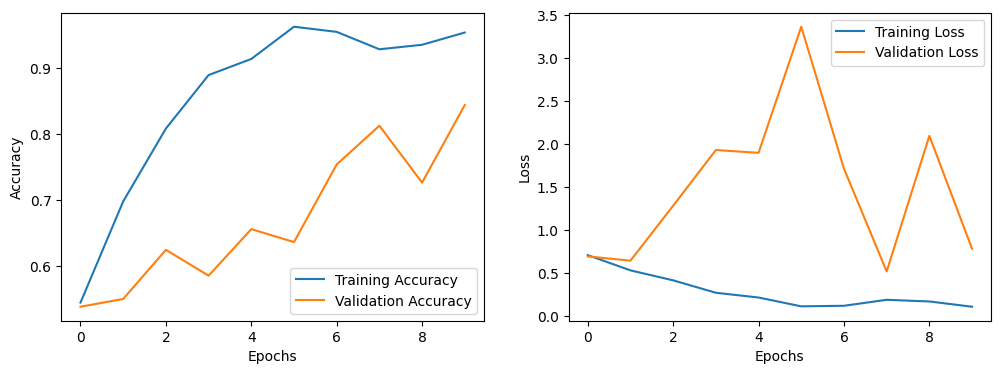

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Используем модель для предсказаний

In [30]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(150,150))

    plt.imshow(img1)

    Y = image.img_to_array(img1)

    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:

        plt.xlabel("human", fontsize=12)


    elif val == 0:

        plt.xlabel("horse", fontsize=12)

1/1 [==============================] - 0s 20ms/step
[[0.]]


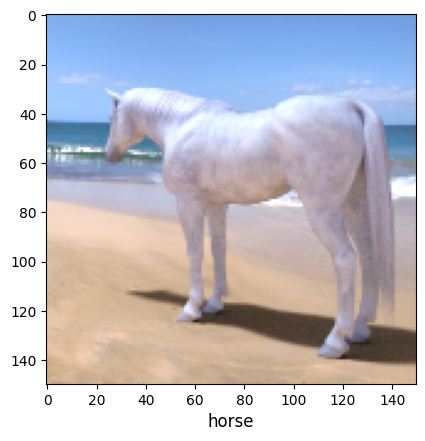

In [31]:
predictImage('/content/horse-or-human/horse-or-human/train/horses/horse01-3.png')

1/1 [==============================] - 0s 19ms/step
[[0.]]


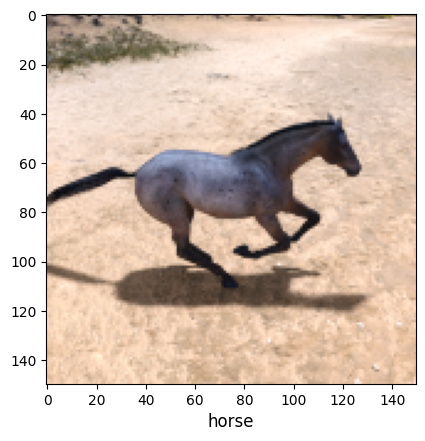

In [32]:
predictImage('/content/horse-or-human/horse-or-human/train/horses/horse22-5.png')

1/1 [==============================] - 0s 20ms/step
[[0.]]


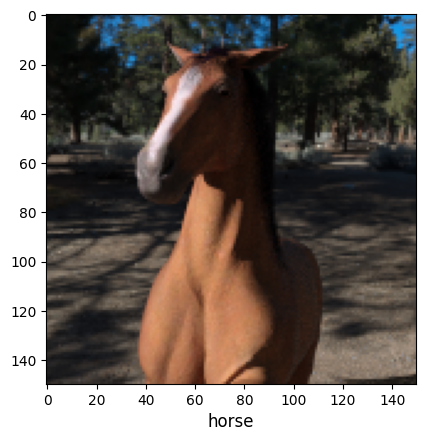

In [33]:
predictImage('/content/horse-or-human/horse-or-human/train/horses/horse48-6.png')

1/1 [==============================] - 0s 26ms/step
[[1.]]


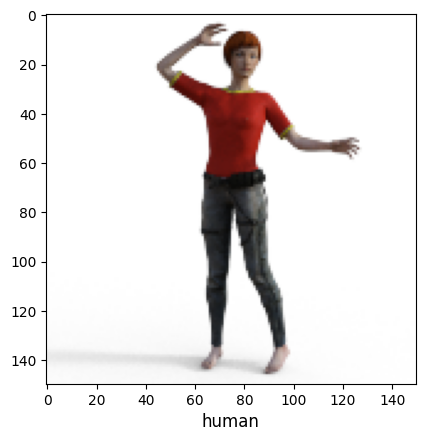

In [34]:
predictImage('/content/horse-or-human/horse-or-human/validation/humans/valhuman04-19.png')

1/1 [==============================] - 0s 28ms/step
[[1.]]


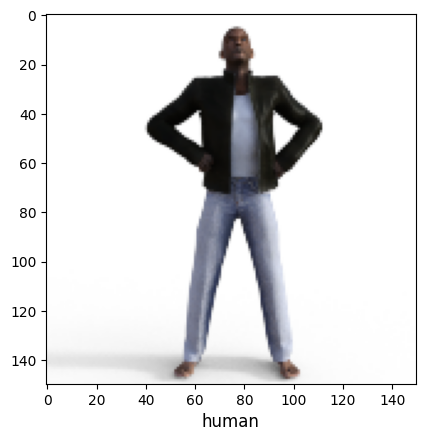

In [35]:
predictImage('/content/horse-or-human/horse-or-human/validation/humans/valhuman03-06.png')